### Modeling

#### Imports

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb

#### Data Preprocessing 

Load Data

In [110]:
def load_data(path='Data/', separate_country=False):
    # Load train and set
    X_train     = pd.read_csv(path+'X_train.csv', index_col='ID')
    Y_train     = pd.read_csv(path+'Y_train.csv', index_col='ID')
    X_test      = pd.read_csv(path+'X_test.csv', index_col='ID')
    Y_test      = pd.read_csv(path+'Y_test.csv', index_col='ID')

    # If separate country return separate dataset for each country
    if separate_country:
        # Join features and target for preprocessing
        train_df    = X_train.join(Y_train)
        test_df     = X_test.join(Y_test)

        # Split training data into DE and FR datasets
        train_fr    = train_df[train_df.COUNTRY=='FR']
        train_de    = train_df[train_df.COUNTRY=='DE']

        # Split test data into DE and FR datasets
        test_fr     = test_df[test_df.COUNTRY=='FR']
        test_de     = test_df[test_df.COUNTRY=='DE']

        X_train_fr  = train_fr.drop(columns=['TARGET','COUNTRY','DAY_ID'])
        X_train_de  = train_de.drop(columns=['TARGET','COUNTRY','DAY_ID'])
        Y_train_fr  = train_fr[['TARGET']]
        Y_train_de  = train_de[['TARGET']]
        
        X_test_fr  = test_fr.drop(columns=['TARGET','COUNTRY','DAY_ID'])
        X_test_de  = test_de.drop(columns=['TARGET','COUNTRY','DAY_ID'])
        Y_test_fr  = test_fr[['TARGET']]
        Y_test_de  = test_de[['TARGET']]
    
        return [X_train_fr, Y_train_fr, X_train_de, Y_train_de, X_test_fr, Y_test_fr, X_test_de, Y_test_de]
    
    # If NOT separate country then return full train and test data
    else:
        ohc                 = OneHotEncoder(drop='first')
        X_train['COUNTRY']  = ohc.fit_transform(X_train.COUNTRY.values.reshape(-1,1)).toarray()
        X_train.drop(columns=['DAY_ID'], inplace=True)
        
        X_test['COUNTRY']   = ohc.fit_transform(X_test.COUNTRY.values.reshape(-1,1)).toarray()
        X_test.drop(columns=['DAY_ID'], inplace=True)
        
        return [X_train, Y_train, X_test, Y_test]

In [111]:
X_train, Y_train, X_test, Y_test = load_data(separate_country=False)

#### Modeling

Helper functions

In [103]:
# Function to compute MSE and MAE
def evaluate_model(model, X_test, Y_test, print_only=False):
    y_preds = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_preds)
    mae = mean_absolute_error(Y_test, y_preds)
    print(f"MSE {mse:.4f}")
    print(f"MAE {mae:.4f}")
    if not print_only: return [mse, mae]

Decision Tree

In [104]:
# Define parameter grid
param_grid_decision_tree = {'max_depth'         :   [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30],
                            'min_samples_split' :   [5, 10, 50, 100],
                            'min_samples_leaf'  :   [10, 50, 100]
                            }

# Define GridSearchCV object
dt = GridSearchCV(
    DecisionTreeRegressor(random_state=1), 
    param_grid=param_grid_decision_tree, 
    cv=10, 
    n_jobs=-1, 
    scoring='neg_mean_squared_error'
)

# Fit GridSearch
dt.fit(X_train, Y_train)

# Print results
print(dt.best_params_)

mse_dt, mae_dt = evaluate_model(dt, X_test, Y_test)

{'max_depth': 2, 'min_samples_leaf': 50, 'min_samples_split': 5}
MSE 1.1361
MAE 0.8558


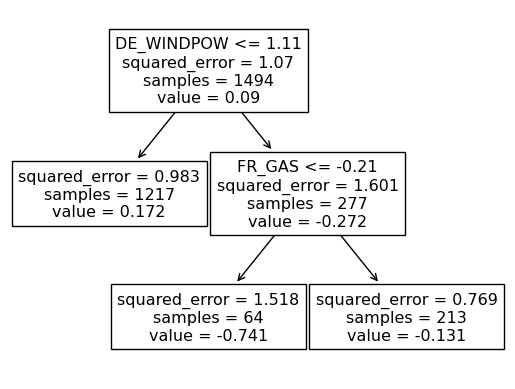

In [105]:
from sklearn.tree import plot_tree
plot_tree(dt.best_estimator_,feature_names=X_train.columns);

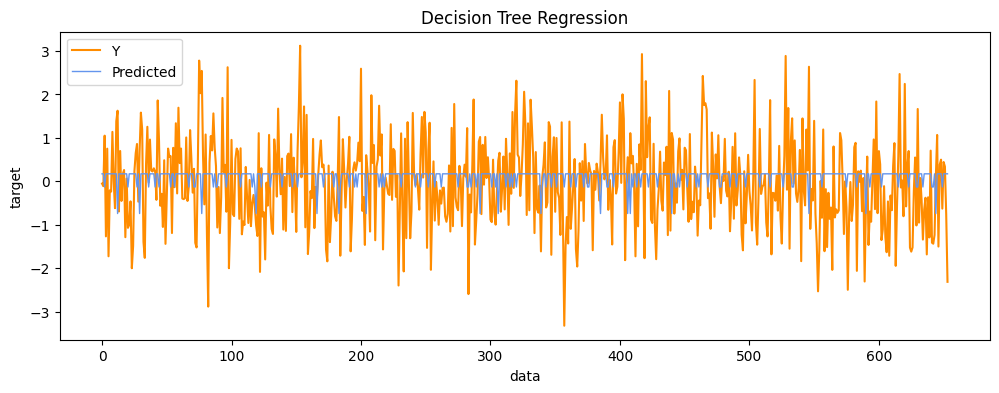

In [106]:
# Display the results
plt.figure(figsize=(12,4))
plt.plot(Y_test.values, c="darkorange", label="Y")
plt.plot(dt.predict(X_test), color="cornflowerblue", label="Predicted", linewidth=1)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

#### Bagging

In [107]:
# Define base estimator
base_estimator = DecisionTreeRegressor()

# Define parameter grid for BaggingRegressor
bagging_param_grid = {
    'estimator'         : [base_estimator],
    'n_estimators'      : [10, 50, 100],
    'max_samples'       : [0.5, 0.7, 1.0],
    'max_features'      : [0.5, 0.7, 1.0],
    'bootstrap'         : [True, False],
    'bootstrap_features': [True, False]
}
param_grid = {**bagging_param_grid}

# Initialize GridSearchCV
bgr_grid = GridSearchCV(
    estimator=BaggingRegressor(),
    param_grid=param_grid,
    cv=5,  # Cross-validation folds
    scoring='neg_mean_squared_error',  # Scoring metric
    n_jobs=-1
)

# Fit GridSearchCV to your data
bgr_grid.fit(X_train, Y_train.values.reshape(-1,1).ravel())

# Get the best parameters
best_params = bgr_grid.best_params_
print("Best hyperparameters:", best_params)

# Evaluate model
mse_bgr, mae_bgr = evaluate_model(bgr_grid,X_test, Y_test)

Best hyperparameters: {'bootstrap': True, 'bootstrap_features': True, 'estimator': DecisionTreeRegressor(), 'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 100}
MSE 1.0980
MAE 0.8432


#### Random Forest

In [109]:
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators':         [50, 100, 150, 300],
    'max_depth':            [None, 5, 10, 15],
    'min_samples_split':    [2, 5, 10],
    'min_samples_leaf':     [1, 2, 4],
    'bootstrap':            [True, False]
}

# Initialize GridSearchCV
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    cv=5,  # Cross-validation folds
    scoring='neg_mean_squared_error',  # Scoring metric
    n_jobs=-1
)

# Fit GridSearchCV to your data
rf_grid.fit(X_train, Y_train)

# Get the best parameters
best_params = rf_grid.best_params_
print("Best hyperparameters:", best_params)

# Evaluate model
mse_rf, mae_rf = evaluate_model(rf_grid, X_test, Y_test)

ValueError: 
All the 810 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/peterkeszthelyi/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/peterkeszthelyi/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/peterkeszthelyi/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py", line 348, in fit
    X, y = self._validate_data(
  File "/Users/peterkeszthelyi/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/peterkeszthelyi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py", line 1146, in check_X_y
    X = check_array(
  File "/Users/peterkeszthelyi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py", line 957, in check_array
    _assert_all_finite(
  File "/Users/peterkeszthelyi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py", line 122, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/peterkeszthelyi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py", line 171, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
